<a href="https://colab.research.google.com/github/Michell203/iGEM/blob/main/WTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch as t
import torch.nn as nn
import torch.optim as optim

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import cv2

# https://www.kaggle.com/code/faduregis/mnist-digit-classification-in-pytorch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = t.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = t.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])

### Replicate [WTA paper](https://www.nature.com/articles/s41586-018-0289-6#Sec2)

In [4]:
# Collect 6's and 7's to replicate WTA paper
sixes = []
sevens = []
for data in mnist_trainset:
  x = data[0]
  y = data[1]

  if y == 6:
    sixes.append(x)
  elif y == 7:
    sevens.append(x)

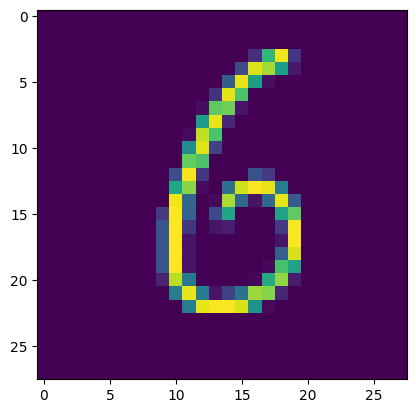

In [5]:
plt.imshow(sixes[1].view(28, 28))
plt.show()

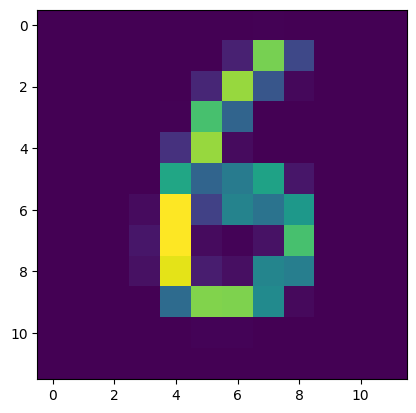

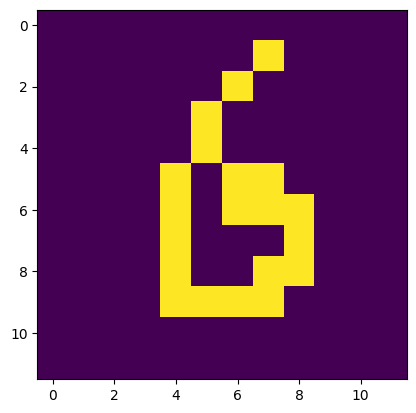

In [6]:
# Scale to 12x12 using Gaussina filter
image_rescaled = rescale(sixes[1], 0.42, anti_aliasing=True) # 0.42 roughly takes 28 to 12
tensor_img = t.tensor(image_rescaled)
plt.imshow(tensor_img.view(12, 12))
plt.show()

# Set largest 20 bits to 1
np_arr = np.array(image_rescaled)[0]
idxs = np.argsort(np_arr.ravel())[-20:]
rows, cols = idxs//len(np_arr), idxs%len(np_arr)

np_arr = np.zeros((len(np_arr), len(np_arr)))
np_arr[rows, cols] = 1
tensor_img = t.tensor(np_arr)
plt.imshow(tensor_img.view(12, 12))
plt.show()

In [7]:
def transform_image(image):
    image_rescaled = rescale(image, 0.42, anti_aliasing=True)
    np_arr = np.array(image_rescaled)[0]
    idxs = np.argsort(np_arr.ravel())[-20:]
    rows, cols = idxs//len(np_arr), idxs%len(np_arr)

    np_arr = np.zeros((len(np_arr), len(np_arr)))
    np_arr[rows, cols] = 1/20
    return np_arr

In [8]:
# Make weight matrices with average values of 100 examples
def weight_matrix(example):
  weight_matrix = np.zeros((12, 12))
  for i in range(100):
    transformed = transform_image(example[i])
    weight_matrix += transformed

  idxs = np.argsort(weight_matrix.ravel())[-20:]
  rows, cols = idxs//len(weight_matrix), idxs%len(weight_matrix)

  save = weight_matrix[rows, cols]
  weight_matrix = np.zeros((len(weight_matrix), len(weight_matrix)))
  weight_matrix[rows, cols] = save
  return weight_matrix / np.sum(weight_matrix)

In [9]:
weight_sixes = weight_matrix(sixes)
weight_sevens = weight_matrix(sevens)

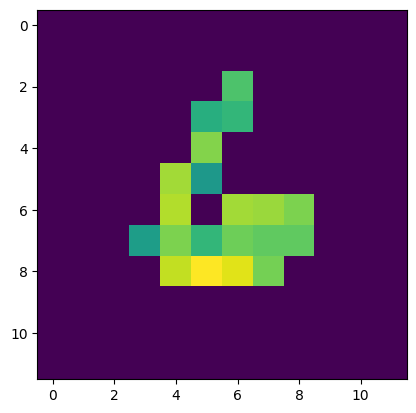

1.0


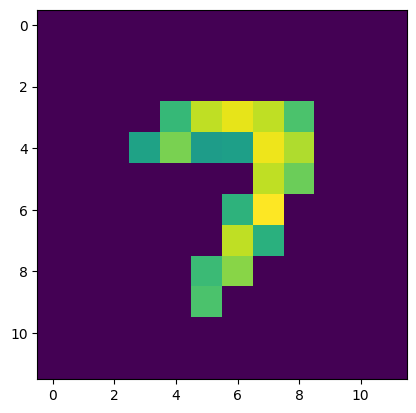

1.0


In [10]:
# Look at example
tensor_six_avg = t.tensor(weight_sixes)
plt.imshow(tensor_six_avg.view(12, 12))
plt.show()
print(np.sum(weight_sixes))
tensor_seven_avg = t.tensor(weight_sevens)
plt.imshow(tensor_seven_avg.view(12, 12))
plt.show()
print(np.sum(weight_sevens))

In [11]:
# Basic Model
def classify(img, weights):
  y1 = 0
  y2 = 0

  for i in range(len(img)):
    for j in range(len(img)):
      y1 += img[i][j] * weights[0][i][j]
      y2 += img[i][j] * weights[1][i][j]

  if y1 > y2:
    return 6
  else:
    return 7

print(classify(transform_image(sixes[5]), (weight_sixes, weight_sevens)))
print(classify(transform_image(sevens[3]), (weight_sixes, weight_sevens)))

6
7


In [12]:
# Test Accuracy
num_correct_sixes = 0
num_correct_sevens = 0

for i in range(5000):
  classification_six = classify(transform_image(sixes[i]), (weight_sixes, weight_sevens))
  classification_seven = classify(transform_image(sevens[i]), (weight_sixes, weight_sevens))

  if classification_six == 6:
    num_correct_sixes += 1

  if classification_seven == 7:
    num_correct_sevens += 1

print(num_correct_sixes/5000)
print(num_correct_sevens/5000)

0.9524
0.977


# Model
Generalize model

In [21]:
# Build model
class GeneralWTA(nn.Module):
    def __init__(self, input_size, mem_num, output_size):
        super(GeneralWTA,self).__init__()
        self.linear1 = nn.Linear(input_size, mem_num)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(mem_num, output_size)

    def forward(self, img):
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

net = GeneralWTA(12*12, 2, 2)

In [22]:
sixes_transformed = []
sevens_transformed = []

In [ ]:
model = nn.Sequential(
    nn.Linear(10*10, 2),
    nn.ReLU(),
    nn.Linear(2, 2)
)